In [40]:
import numpy as np
import pandas as pd
import pickle, csv
import os

from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Input, concatenate, Flatten, Reshape,MaxPooling2D, Conv2D, TimeDistributed
from keras import regularizers
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models


from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow.keras.backend as K
K.clear_session()

In [41]:
# Load powerprice data and format it
df_powerprice = pd.read_csv("data/PowerPrice.csv")
df_powerprice["Time"] = pd.to_datetime(df_powerprice["Time"], infer_datetime_format=True)
df_powerprice = df_powerprice.drop(columns=["Time"])
df_powerprice

,DayAhead,Spot,REBAP
0,2.83200,3.688,-4.566
1,2.37575,4.245,-13.964
2,1.91950,3.161,0.345
3,1.46325,1.664,3.048
4,1.00700,3.110,-6.679
...,...,...,...
35035,3.77625,3.342,4.856
35036,3.73900,4.425,8.561
35037,3.70175,2.473,6.076
35038,3.66450,3.241,11.797


In [42]:
# Load spatial data and format it
datasets = []
for filename in os.listdir("data/Spatial"):
    if filename.endswith(".pickle"):
        with open(os.path.join("data/Spatial", filename), "rb") as file:
            data = pickle.load(file)
            if data.shape == (100, 35040):
                datasets.append(data)
                print(filename)
            else:
                print(f"Skipping {filename}: unexpected shape {data.shape}")

biogas_kw_2019.pickle
brown_coal_kw_2019.pickle
completed_solar_kw_2019.pickle
completed_wind_onshore_kw_2019.pickle
demand_kw_2019.pickle
hard_coal_kw_2019.pickle
nuclear_kw_2019.pickle
oil_kw_2019.pickle
water_laufwasser_kw_2019.pickle
water_pumpspeicher_PB_kw_2019.pickle
water_pumpspeicher_TB_kw_2019.pickle
water_speicherwasser_kw_2019.pickle
wind_offshore_kw_2019.pickle


In [43]:
# Convert the list of arrays to a 3D array
spatial_data = np.stack(datasets, axis=0)

spatial_data = spatial_data.reshape((spatial_data.shape[0], spatial_data.shape[1], spatial_data.shape[2]))

# transpose the second and third dimensions to get shape (13, 35040, 100)
spatial_data = spatial_data.transpose((0, 1, 2))

spatial_data.shape

(13, 100, 35040)

In [44]:
# Load mask and reshape to match desired output shape
mask = pd.read_csv("germany/mask.csv", header=None).values
#mask = mask_df.values.reshape((40, 40, 1))

mask.shape

(30, 30)

In [45]:
spatial_data.shape

(13, 100, 35040)

In [46]:
image_all = np.zeros((35040, 30, 30, 13))
for j in range(spatial_data.shape[2]):
    for i in range(spatial_data.shape[0]):
        image = np.zeros((30, 30))
        for s in range(spatial_data.shape[1]):
            image[mask == s] = spatial_data[i,s,j]
        #print(i)
        image_all[j, :, :, i] = image

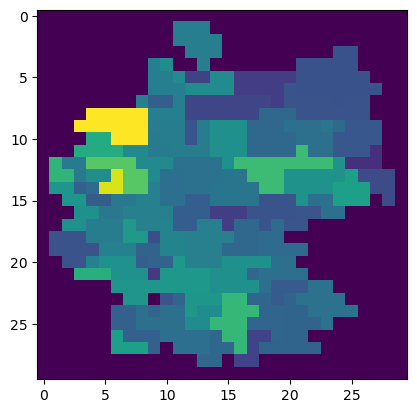

In [47]:
plt.imshow(image_all[35030,:,:,4])
plt.show()

In [48]:
image_all.shape

(35040, 30, 30, 13)

In [49]:
#input_2 = df_powerprice["DayAhead"].values.reshape((-1, 4))
#input_2.shape

In [50]:
output = df_powerprice["Spot"].values

scaler = MinMaxScaler()
output = scaler.fit_transform(output.reshape(-1, 1))

output

array([[0.34239157],
       [0.34917003],
       [0.33597819],
       ...,
       [0.32760551],
       [0.33695176],
       [0.33731685]])

In [51]:
def split_datasets(df, df2, window_size, look_ahead):
    X = []
    y = []
    for i in range(len(df) - window_size - look_ahead + 1):
        row = df[i:i+window_size, :, :, :]
        X.append(row)
        label = df2[i+window_size+look_ahead-1]
        y.append(label)
    return np.array(X), np.array(y)

In [52]:
window_size = 4
look_ahead = 1
X, y = split_datasets(image_all, output, window_size=window_size, look_ahead=look_ahead)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (35036, 4, 30, 30, 13), y shape: (35036, 1)


In [53]:
# Reshape the input array to a 2D array
input_2d = X.reshape(-1, X.shape[-1])

# Scale the array using MinMaxScaler
scaler = MinMaxScaler()
input_scaled = scaler.fit_transform(input_2d)

# Reshape the scaled array back to the original shape
X = input_scaled.reshape(X.shape)

print("Scaled X shape:", X.shape)

Scaled X shape: (35036, 4, 30, 30, 13)


In [54]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=30)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (17167, 4, 30, 30, 13)
y_train shape: (17167, 1)
X_val shape: (7358, 4, 30, 30, 13)
y_val shape: (7358, 1)
X_test shape: (10511, 4, 30, 30, 13)
y_test shape: (10511, 1)


In [55]:
time_steps = 4
width = 30
height = 30
channel = 13

# Define the input layer
input_layer = Input(shape=(time_steps, width, height, channel))

# Define the convolutional layers
cnn1 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')
cnn2 = MaxPooling2D(pool_size=(2, 2))
cnn3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')
cnn4 = MaxPooling2D(pool_size=(2, 2))

# Apply TimeDistributed to the convolutional layers
td_cnn1 = TimeDistributed(cnn1)(input_layer)
td_cnn2 = TimeDistributed(cnn2)(td_cnn1)
td_cnn3 = TimeDistributed(cnn3)(td_cnn2)
td_cnn4 = TimeDistributed(cnn4)(td_cnn3)

# Reshape the output of the convolutional layers
reshaped = Reshape((-1, 6*6*32))(td_cnn4)

# Apply TimeDistributed Dense layer
td_fcnn = TimeDistributed(Dense(10, activation='relu', name='output'))(reshaped)

# Apply LSTM layer
lstm_output = LSTM(1, name='lstm1_1')(td_fcnn)

# Create the model
model = Model(inputs=input_layer, outputs=lstm_output)

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 30, 30, 13)]   0         
                                                                 
 time_distributed (TimeDistr  (None, 4, 28, 28, 16)    1888      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 14, 14, 16)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 4, 12, 12, 32)    4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 4, 6, 6, 32)      0         
 tributed)                                                   

In [56]:
# Compile the model with an appropriate optimizer and loss function

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [57]:
# Define callbacks for early stopping and checkpoint saving
es = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)

In [ ]:
today = datetime.datetime.now().strftime("%Y-%m-%d--%H-%M")

In [58]:
cp = ModelCheckpoint(filepath=f"training/model-website/model-{today}.h5", 
                      save_best_only=True,
                      monitor='val_loss', 
                      mode='min', 
                      save_weights_only=False, 
                      verbose=1)

In [59]:
# Fit the model on the training data
history = model.fit(X_train, y_train, batch_size=30, epochs=1000, validation_data=(X_val, y_val), callbacks=[cp, es])

Epoch 1/1000
571/573 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0505
Epoch 1: val_loss improved from inf to 0.00040, saving model to training/model-website\model10.h5
573/573 [==============================] - 10s 13ms/step - loss: 0.0025 - root_mean_squared_error: 0.0505 - val_loss: 3.9615e-04 - val_root_mean_squared_error: 0.0199
Epoch 2/1000
570/573 [============================>.] - ETA: 0s - loss: 3.5871e-04 - root_mean_squared_error: 0.0189
Epoch 2: val_loss improved from 0.00040 to 0.00032, saving model to training/model-website\model10.h5
573/573 [==============================] - 7s 12ms/step - loss: 3.5794e-04 - root_mean_squared_error: 0.0189 - val_loss: 3.2329e-04 - val_root_mean_squared_error: 0.0180
Epoch 3/1000
571/573 [============================>.] - ETA: 0s - loss: 3.1680e-04 - root_mean_squared_error: 0.0178
Epoch 3: val_loss improved from 0.00032 to 0.00030, saving model to training/model-website\model10.h5
573/573 [=====

Epoch 23/1000
567/573 [============================>.] - ETA: 0s - loss: 2.0528e-04 - root_mean_squared_error: 0.0143
Epoch 23: val_loss did not improve from 0.00020
573/573 [==============================] - 5s 9ms/step - loss: 2.0486e-04 - root_mean_squared_error: 0.0143 - val_loss: 1.9816e-04 - val_root_mean_squared_error: 0.0141
Epoch 24/1000
570/573 [============================>.] - ETA: 0s - loss: 2.0217e-04 - root_mean_squared_error: 0.0142
Epoch 24: val_loss improved from 0.00020 to 0.00020, saving model to training/model-website\model10.h5
573/573 [==============================] - 6s 10ms/step - loss: 2.0227e-04 - root_mean_squared_error: 0.0142 - val_loss: 1.9619e-04 - val_root_mean_squared_error: 0.0140
Epoch 25/1000
571/573 [============================>.] - ETA: 0s - loss: 1.9967e-04 - root_mean_squared_error: 0.0141
Epoch 25: val_loss improved from 0.00020 to 0.00019, saving model to training/model-website\model10.h5
573/573 [==============================] - 5s 9ms/ste

Epoch 46/1000
566/573 [============================>.] - ETA: 0s - loss: 1.6836e-04 - root_mean_squared_error: 0.0130
Epoch 46: val_loss improved from 0.00016 to 0.00016, saving model to training/model-website\model10.h5
573/573 [==============================] - 5s 9ms/step - loss: 1.6745e-04 - root_mean_squared_error: 0.0129 - val_loss: 1.6391e-04 - val_root_mean_squared_error: 0.0128
Epoch 47/1000
572/573 [============================>.] - ETA: 0s - loss: 1.6605e-04 - root_mean_squared_error: 0.0129
Epoch 47: val_loss did not improve from 0.00016
573/573 [==============================] - 5s 9ms/step - loss: 1.6600e-04 - root_mean_squared_error: 0.0129 - val_loss: 1.6491e-04 - val_root_mean_squared_error: 0.0128
Epoch 48/1000
573/573 [==============================] - ETA: 0s - loss: 1.6738e-04 - root_mean_squared_error: 0.0129
Epoch 48: val_loss improved from 0.00016 to 0.00016, saving model to training/model-website\model10.h5
573/573 [==============================] - 5s 10ms/ste

573/573 [==============================] - 6s 11ms/step - loss: 1.3880e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.4119e-04 - val_root_mean_squared_error: 0.0119
Epoch 93/1000
567/573 [============================>.] - ETA: 0s - loss: 1.3872e-04 - root_mean_squared_error: 0.0118
Epoch 93: val_loss did not improve from 0.00014
573/573 [==============================] - 5s 9ms/step - loss: 1.3832e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.4996e-04 - val_root_mean_squared_error: 0.0122
Epoch 94/1000
568/573 [============================>.] - ETA: 0s - loss: 1.3987e-04 - root_mean_squared_error: 0.0118
Epoch 94: val_loss did not improve from 0.00014
573/573 [==============================] - 6s 10ms/step - loss: 1.3993e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.4460e-04 - val_root_mean_squared_error: 0.0120
Epoch 95/1000
570/573 [============================>.] - ETA: 0s - loss: 1.3999e-04 - root_mean_squared_error: 0.0118
Epoch 95: val_loss did not improve from 0

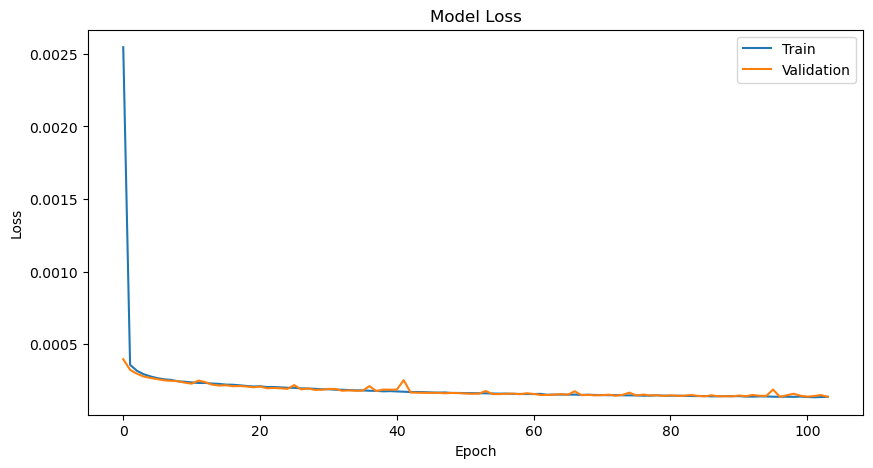

In [60]:
#Plot the training and validation loss

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

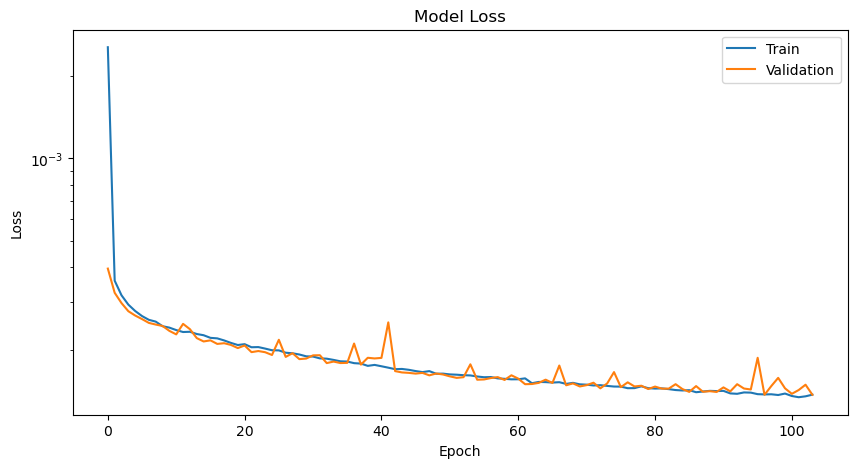

In [61]:
# Plot the training and validation loss on a logarithmic scale
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


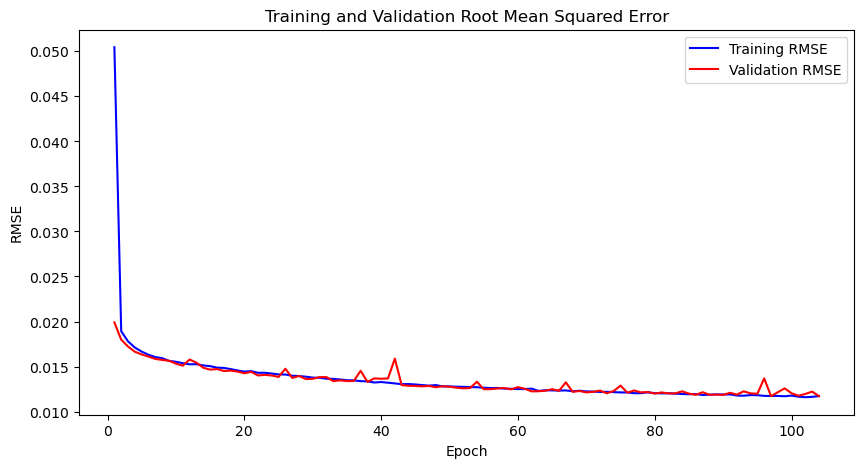

In [62]:
# Get the training and validation accuracy values from the history object
train_acc = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']

# Create a plot of training and validation accuracy
epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_acc, 'b', label='Training RMSE')
plt.plot(epochs, val_acc, 'r', label='Validation RMSE')
plt.title('Training and Validation Root Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [63]:
# After training, print actual and predicted values for the validation data
y_val_pred = model.predict(X_val)
print("Actual\t\tPredicted")
for i in range(len(y_val)):
    print(f"{y_val[i]}\t{y_val_pred[i]}")

230/230 [==============================] - 2s 3ms/step
Actual		Predicted
[0.37556589]	[0.35592994]
[0.34940126]	[0.3413544]
[0.35030181]	[0.3508638]
[0.3384973]	[0.33973488]
[0.35782262]	[0.34590834]
[0.35686122]	[0.34945688]
[0.32461179]	[0.3285439]
[0.34313391]	[0.33915403]
[0.35693424]	[0.3606191]
[0.33539405]	[0.3351238]
[0.35787129]	[0.3473175]
[0.33328871]	[0.33980513]
[0.3502653]	[0.33650663]
[0.33990897]	[0.34362218]
[0.3887699]	[0.38067514]
[0.34054179]	[0.33166775]
[0.34027406]	[0.35096732]
[0.37661247]	[0.37720156]
[0.35770092]	[0.3511302]
[0.33485859]	[0.33718336]
[0.31633646]	[0.30528793]
[0.32003602]	[0.3264571]
[0.27756413]	[0.29121444]
[0.33880154]	[0.3350072]
[0.36316507]	[0.35167783]
[0.35028964]	[0.34537452]
[0.31070194]	[0.3157003]
[0.33510198]	[0.3308572]
[0.33740203]	[0.33386266]
[0.36053644]	[0.3647555]
[0.37192718]	[0.3442213]
[0.31836879]	[0.32983956]
[0.3329723]	[0.3376393]
[0.34963248]	[0.34126145]
[0.34150319]	[0.34802452]
[0.34171007]	[0.3444413]
[0.3200481

[0.3384973]	[0.34336495]
[0.31369566]	[0.33106047]
[0.35863798]	[0.33841103]
[0.35513314]	[0.35115108]
[0.35149443]	[0.3546348]
[0.35692207]	[0.34693563]
[0.34977851]	[0.3553853]
[0.34012802]	[0.33749446]
[0.3462615]	[0.3463299]
[0.35379448]	[0.3586423]
[0.28313781]	[0.3099264]
[0.35613104]	[0.35386342]
[0.34179526]	[0.3303989]
[0.30896169]	[0.3362298]
[0.35280874]	[0.35133016]
[0.33838777]	[0.3409752]
[0.34248893]	[0.34552473]
[0.33895974]	[0.3378492]
[0.36926204]	[0.36320144]
[0.33955605]	[0.34894645]
[0.41015188]	[0.40939492]
[0.34046877]	[0.34436485]
[0.36804508]	[0.36248884]
[0.31713966]	[0.30283526]
[0.33226647]	[0.35195187]
[0.34413182]	[0.32554403]
[0.37795113]	[0.3873166]
[0.29533174]	[0.31905594]
[0.34351117]	[0.32772085]
[0.35411089]	[0.34269065]
[0.33584433]	[0.3370207]
[0.36104756]	[0.34594494]
[0.3224456]	[0.31775835]
[0.36304337]	[0.35108572]
[0.36666991]	[0.35501203]
[0.37382563]	[0.3751212]
[0.33779146]	[0.34135568]
[0.35658132]	[0.3518199]
[0.34519058]	[0.35108608]
[0

[0.35540087]	[0.34730792]
[0.34094339]	[0.34275952]
[0.32983255]	[0.32359415]
[0.36260527]	[0.36004052]
[0.33731685]	[0.34165305]
[0.33943436]	[0.33397898]
[0.33395804]	[0.34097195]
[0.35493842]	[0.34869042]
[0.73355888]	[0.5897634]
[0.40592903]	[0.40118626]
[0.3378158]	[0.3382451]
[0.32879813]	[0.31959224]
[0.32292022]	[0.32587212]
[0.31879472]	[0.3320566]
[0.34599377]	[0.33872315]
[0.34740544]	[0.3400946]
[0.37056418]	[0.35897577]
[0.34701602]	[0.36517003]
[0.33894757]	[0.33400074]
[0.29724237]	[0.3179254]
[0.32764202]	[0.32948455]
[0.35048435]	[0.34694046]
[0.34858589]	[0.34862417]
[0.37633257]	[0.3644109]
[0.35226111]	[0.35241106]
[0.33135375]	[0.3347673]
[0.33443265]	[0.33222583]
[0.32591394]	[0.3339402]
[0.3722801]	[0.36094728]
[0.34963248]	[0.35411942]
[0.33944653]	[0.33117616]
[0.35417174]	[0.34945428]
[0.33592951]	[0.32593003]
[0.35551039]	[0.37668675]
[0.33819306]	[0.34860185]
[0.34773402]	[0.34212685]
[0.32180061]	[0.32716253]
[0.35647179]	[0.3482495]
[0.32983255]	[0.3384527

[0.36497834]	[0.3819004]
[0.36104756]	[0.3665227]
[0.33870418]	[0.34585312]
[0.34641971]	[0.34916306]
[0.33794967]	[0.341644]
[0.3391788]	[0.3380979]
[0.34173441]	[0.34919438]
[0.3810422]	[0.35401088]
[0.36645086]	[0.32789385]
[0.3580295]	[0.34607458]
[0.33149978]	[0.33144453]
[0.35117802]	[0.3571008]
[0.33440831]	[0.3368142]
[0.3517865]	[0.34834984]
[0.34693083]	[0.34215328]
[0.31234484]	[0.3090905]
[0.3529061]	[0.3517928]
[0.35103198]	[0.34582314]
[0.33746288]	[0.33556008]
[0.32627902]	[0.32909766]
[0.34049311]	[0.34962445]
[0.35153094]	[0.34749562]
[0.31312369]	[0.31657568]
[0.33254637]	[0.32375216]
[0.34582339]	[0.34376043]
[0.32156939]	[0.32316422]
[0.33536971]	[0.33495733]
[0.33530886]	[0.33188114]
[0.35100764]	[0.35793507]
[0.343499]	[0.3287847]
[0.34251326]	[0.34297237]
[0.34475247]	[0.3309421]
[0.36402911]	[0.35404587]
[0.35454899]	[0.3495209]
[0.34304873]	[0.3469367]
[0.33714647]	[0.34069052]
[0.32988122]	[0.32884043]
[0.32898067]	[0.3311041]
[0.32663194]	[0.3337677]
[0.34352

In [64]:
y_val.shape

(7358, 1)

In [65]:
y_val_pred.shape

(7358, 1)

In [66]:
# Define the minimum and maximum values of the original data
min_price = df_powerprice["Spot"].min()
max_price = df_powerprice["Spot"].max()

# Inverse transform the scaled actual values (y_val)
y_val_original = (y_val * (max_price - min_price)) + min_price

# Inverse transform the scaled predicted values (y_val_pred)
y_val_pred_original = (y_val_pred * (max_price - min_price)) + min_price

# Print the original actual and predicted values
print("Actual\t\tPredicted")
for i in range(len(y_val_original)):
    actual = y_val_original[i]
    predicted = y_val_pred_original[i]
    print(f"{actual}\t{predicted}")

Actual		Predicted
[6.414]	[4.800474]
[4.264]	[3.6027718]
[4.338]	[4.38418]
[3.368]	[3.4696941]
[4.956]	[3.9769783]
[4.877]	[4.268568]
[2.227]	[2.550108]
[3.749]	[3.4219646]
[4.883]	[5.185791]
[3.113]	[3.0907917]
[4.96]	[4.0927715]
[2.94]	[3.4754658]
[4.335]	[3.204422]
[3.484]	[3.7891197]
[7.499]	[6.8338356]
[3.536]	[2.8068008]
[3.514]	[4.392685]
[6.5]	[6.5484047]
[4.946]	[4.406069]
[3.069]	[3.2600288]
[1.547]	[0.6391182]
[1.851]	[2.3786316]
[-1.639]	[-0.51732826]
[3.393]	[3.0812092]
[5.395]	[4.451069]
[4.337]	[3.933113]
[1.084]	[1.4947224]
[3.089]	[2.7401962]
[3.278]	[2.9871616]
[5.179]	[5.525688]
[6.115]	[3.8383503]
[1.714]	[2.6565742]
[2.914]	[3.297495]
[4.283]	[3.5951347]
[3.615]	[4.1508694]
[3.632]	[3.8564281]
[1.852]	[1.908844]
[4.058]	[3.4335232]
[3.905]	[4.0231037]
[5.552]	[5.3432884]
[4.796]	[4.863188]
[3.37]	[3.2519207]
[5.423]	[4.765312]
[2.54]	[2.3205128]
[4.152]	[4.4101257]
[5.582]	[6.583868]
[1.446]	[1.2165928]
[3.83]	[3.8156052]
[3.287]	[2.6621208]
[2.962]	[2.2752838]
[4.

[2.883]	[3.0781288]
[6.963]	[5.06876]
[3.66]	[3.7041645]
[3.383]	[3.0307617]
[3.571]	[3.158636]
[2.478]	[2.3682785]
[2.344]	[3.3249397]
[2.801]	[0.1494484]
[2.121]	[2.7769947]
[3.5]	[3.4241257]
[4.983]	[5.16547]
[3.634]	[3.415575]
[3.324]	[3.7971992]
[5.934]	[8.018324]
[0.453]	[-0.4105072]
[3.911]	[3.5687885]
[3.81]	[2.9921055]
[-0.268]	[-0.31754875]
[5.847]	[5.0704784]
[4.302]	[3.3851166]
[3.292]	[3.4030418]
[1.129]	[0.6168308]
[4.414]	[4.569721]
[5.13]	[4.8590164]
[3.921]	[3.4017963]
[2.851]	[2.8196487]
[2.88]	[3.2848148]
[4.094]	[3.6305962]
[2.85]	[3.04282]
[2.882]	[3.1547813]
[4.086]	[2.9349213]
[5.09]	[3.525528]
[7.823]	[5.617113]
[3.179]	[2.7993736]
[4.721]	[4.1134815]
[3.265]	[3.4992046]
[8.773]	[4.5744724]
[2.964]	[3.2092018]
[2.432]	[2.265295]
[2.606]	[3.0758266]
[3.492]	[3.1823597]
[3.655]	[3.9323483]
[4.64]	[4.158285]
[3.68]	[3.04488]
[4.574]	[4.2205906]
[3.553]	[2.4621086]
[3.145]	[3.7694263]
[3.99]	[4.208338]
[3.478]	[3.1483097]
[4.199]	[4.219288]
[7.461]	[7.341984]
[4.812

[5.668]	[6.6535873]
[4.67]	[5.7663155]
[1.621]	[0.9051094]
[5.222]	[6.216175]
[3.164]	[3.2832508]
[4.954]	[4.4880867]
[3.764]	[3.6130161]
[3.456]	[4.3179703]
[3.207]	[3.300661]
[5.693]	[5.618885]
[3.059]	[3.2913322]
[2.689]	[1.9609718]
[4.612]	[5.0451374]
[2.847]	[4.334364]
[2.463]	[2.3133354]
[5.303]	[4.77981]
[5.503]	[6.7667828]
[3.666]	[3.448185]
[3.046]	[2.2399826]
[2.864]	[1.0565109]
[3.076]	[2.5855331]
[2.787]	[3.1730976]
[3.511]	[3.4529762]
[3.244]	[3.2285004]
[4.304]	[3.53483]
[8.585]	[10.536406]
[-2.69]	[-0.12007523]
[3.854]	[2.150732]
[1.856]	[2.3562489]
[5.659]	[4.0820274]
[4.704]	[4.4354973]
[4.904]	[5.3038063]
[5.201]	[4.978983]
[3.881]	[2.6328888]
[3.826]	[4.0708523]
[2.766]	[3.5302544]
[5.04]	[4.3066406]
[6.144]	[7.0538177]
[2.032]	[2.3671227]
[1.464]	[3.8745365]
[2.78]	[3.5733776]
[1.107]	[0.4938221]
[3.039]	[3.1451454]
[2.861]	[3.6850052]
[4.235]	[3.6356297]
[-1.004]	[1.8139839]
[5.311]	[5.812025]
[4.323]	[4.25161]
[5.61]	[5.2531414]
[4.117]	[2.8465595]
[5.505]	[4.9989

[3.423]	[2.0706253]
[4.52]	[4.248472]
[0.92]	[0.29908562]
[3.147]	[4.0658607]
[3.141]	[2.063305]
[4.696]	[3.0828419]
[4.637]	[4.6068764]
[4.407]	[3.4029388]
[2.272]	[-0.14684868]
[3.666]	[4.097563]
[3.906]	[3.9254417]
[5.019]	[4.4917564]
[2.963]	[3.7953396]
[13.809]	[17.045683]
[3.669]	[4.5524464]
[3.217]	[2.8749695]
[5.205]	[4.6474895]
[5.18]	[4.6690273]
[4.037]	[3.313284]
[4.91]	[3.8898811]
[5.744]	[5.8881016]
[4.022]	[2.673975]
[-2.218]	[-1.3093452]
[4.507]	[4.0226994]
[5.076]	[4.7914295]
[6.062]	[5.4489326]
[-1.991]	[-3.6347675]
[3.952]	[3.972458]
[4.848]	[5.665039]
[5.113]	[4.759432]
[3.191]	[3.6871147]
[2.736]	[3.304922]
[5.339]	[4.823683]
[2.103]	[2.5622196]
[4.547]	[3.715168]
[4.203]	[4.597069]
[3.851]	[3.775751]
[3.491]	[4.301073]
[4.752]	[3.8478565]
[4.816]	[4.0799026]
[11.736]	[6.326805]
[5.021]	[5.053751]
[7.635]	[6.6873627]
[3.239]	[1.9304581]
[6.516]	[5.4860535]
[5.383]	[4.89727]
[4.254]	[4.346739]
[-2.037]	[0.1969719]
[-0.828]	[0.76686096]
[2.427]	[2.757492]
[1.003]	[1.9

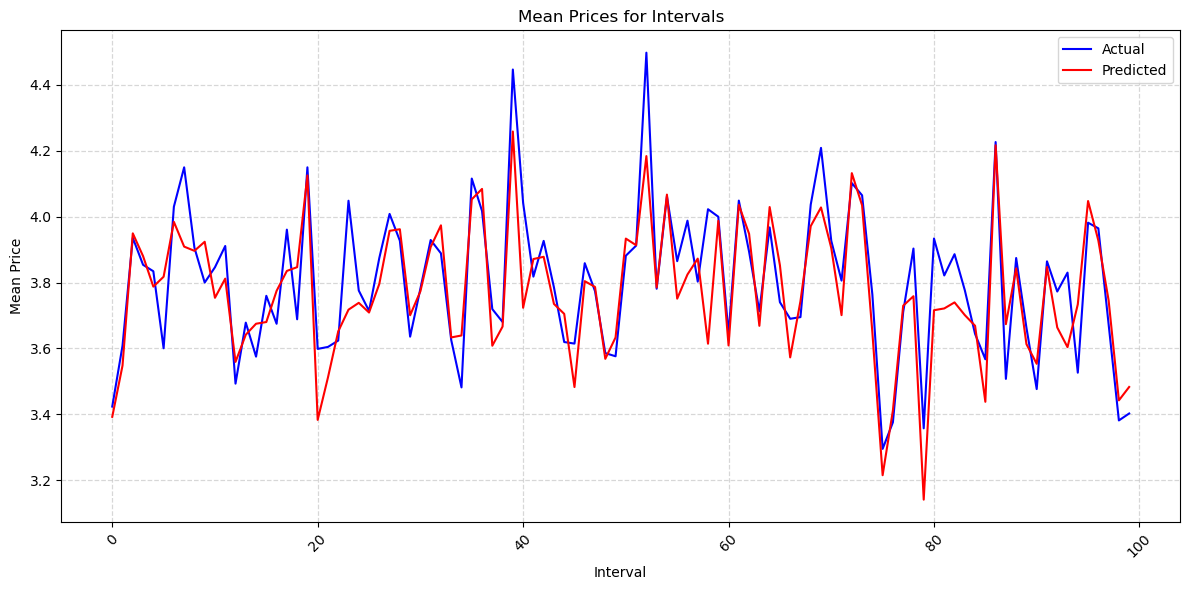

In [67]:
# Define the number of intervals
num_intervals = 100

# Calculate the interval size
interval_size = len(y_val_original) // num_intervals

# Calculate the means for each interval
interval_means_actual = [np.mean(y_val_original[i * interval_size:(i + 1) * interval_size]) for i in range(num_intervals)]
interval_means_pred = [np.mean(y_val_pred_original[i * interval_size:(i + 1) * interval_size]) for i in range(num_intervals)]

# Generate x-axis values for the intervals
x_values = np.arange(num_intervals)

# Plotting the interval means
plt.figure(figsize=(12, 6))
plt.plot(x_values, interval_means_actual, label='Actual', color='blue')
plt.plot(x_values, interval_means_pred, label='Predicted', color='red')
plt.xlabel('Interval')
plt.ylabel('Mean Price')
plt.title('Mean Prices for Intervals')
plt.legend()

# Customize the appearance of the plot
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.9, alpha=0.5)

plt.tight_layout()
plt.show()